In [2]:
from scipy.optimize import minimize
from scipy.optimize import Bounds
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0,'../../pySEMP/')
from scipy.optimize import curve_fit
import SEMP
import pyswarms
import radiospectra



In [3]:
from radiospectra.spectrogram2 import sources

2022-06-29 13:39:56,738 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2022-06-29 13:39:56,739 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.


In [4]:
sources.SWavesSpectrogram

radiospectra.spectrogram2.sources.swaves.SWavesSpectrogram

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
event_data =  np.load('./event2022.npz')

In [7]:

# the dynamic spectrum data
data_WI = event_data['ds_wind'].T
data_STA = event_data['ds_sta'].T
data_SOLO = event_data['ds_solo'].T
data_PSP = event_data['ds_psp']

ds_t_WI = event_data['t_wind']
ds_f_WI = event_data['f_wind']
ds_t_STA = event_data['t_sta']
ds_f_STA = event_data['f_sta']
ds_t_PSP = event_data['t_psp']
ds_f_PSP = event_data['f_psp']
ds_t_SOLO = event_data['t_solo']
ds_f_SOLO = event_data['f_solo']

#anchor_dt = event_data['anchor_dt']

t_start = event_data['t_start']
trange = event_data['trange']

In [8]:
# the solutions (peak time)
#freq_PSP = event_data['f_psp']
#t_PSP = event_data['t_psp']
#freq_WI  = event_data['f_wind']*1e3
#freq_STA = event_data['f_sta']*1e3
#t_WI  = event_data['t_wind']
#t_STA = event_data['t_sta']


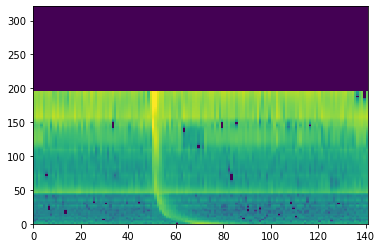

In [109]:
f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO


freq_idx_select =  np.arange(2,80,2)
t_idx = np.where(t_cur<trange[1])[0]
ds_small = ds_cur[t_idx,:]
ds_small[ds_small<1]=1
t_small = t_cur[t_idx]

plt.pcolormesh(np.log10(ds_small.T),vmin=0,vmax=5)

In [11]:
def bi_gaussian(x,x0,A,mu1,mu2,l0):
    mu =  mu1*(x<x0)+mu2*(x>=x0)
    return l0+ A* np.exp(-(x-x0)**2.0/mu**2.)

In [12]:
datatmp=ds_small[:,22]

popt, pcov = curve_fit(bi_gaussian, t_small, datatmp,
bounds=([0,np.max(datatmp)/2,1,1,np.min(datatmp)/2], 
  [np.max(t_small), np.max(datatmp)*2, np.max(t_small) ,np.max(t_small), np.mean(datatmp)]))

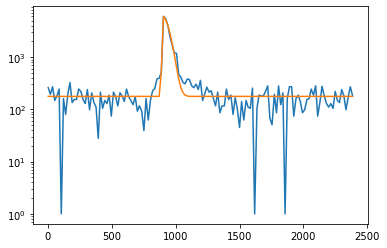

In [13]:
plt.plot(t_small,datatmp.ravel())
plt.plot(t_small,bi_gaussian(t_small,*popt))
plt.yscale('log')

C:\Users\Pjer1\AppData\Local\Temp\ipykernel_39896\664523972.py:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(t_small, f_cur,np.log10(ds_small.T),vmax=5)


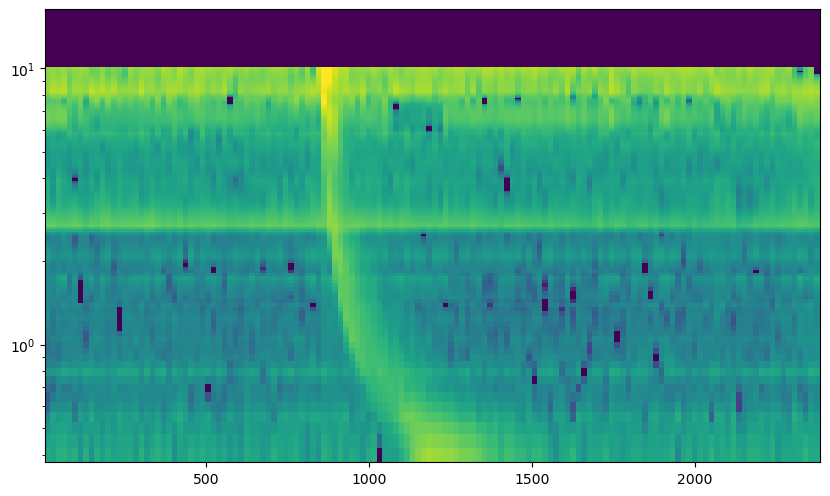

In [110]:
plt.figure(figsize=[10,6],dpi=100)
plt.pcolor(t_small, f_cur,np.log10(ds_small.T),vmax=5)
plt.yscale('log')
#plt.ylim([0.2,12])

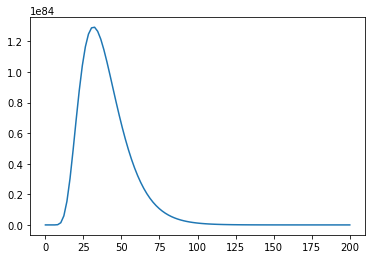

In [104]:
t =  np.linspace(0.1,200,100)
plt.plot(t,np.exp(-0.1*t-100/t+200))

In [77]:
def decay_t(x,t0,c0,c1,c2,l0):
    t = x -10.0
    return l0+ np.exp(-c0*t-c1/t+c2)

In [87]:
f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO


freq_idx_select =  np.arange(2,80,2)
t_idx = np.where(t_cur<trange[1])[0]
ds_small = ds_cur[t_idx,:]
ds_small[ds_small<1]=1
t_small = t_cur[t_idx]

peak_collect = []
peak_fit_collect = []
f_fit_collect = []
for idx in freq_idx_select:
    try:
        data_flux_curve =  ds_small[:,int(idx)]
        peak_loc = np.argmax(data_flux_curve)
        peak_collect.append(t_small[peak_loc])

        f_fit_collect.append(f_cur[idx])
    except:
        pass

    

In [88]:
popt, pcov = curve_fit(decay_t, t_small, data_flux_curve)

c:\Users\Pjer1\anaconda3\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [111]:


f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO
freq_idx_select =  np.arange(2,80,2)
    


def collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select):
        
    t_idx = np.where(t_cur<trange[1])[0]
    ds_small = ds_cur[t_idx,:]
    ds_small[ds_small<1]=1
    t_small = t_cur[t_idx]

    peak_collect = []
    f_fit_collect = []
    for idx in freq_idx_select:
        try:
            data_flux_curve =  ds_small[:,int(idx)]
            peak_loc = np.argmax(data_flux_curve)
            peak_collect.append(t_small[peak_loc])

            f_fit_collect.append(f_cur[idx])
        except:
            pass

    return (f_fit_collect,peak_collect,ds_small,t_small)

In [117]:
print(data_WI.shape,data_PSP.shape,data_STA.shape,data_SOLO.shape)

(881, 280) (7563, 128) (1516, 319) (3088, 321)


In [149]:


f_cur  = ds_f_SOLO
t_cur  =  ds_t_SOLO
ds_cur  =  data_SOLO
freq_idx_select =  np.arange(2,80,2)

(f_fit_collectSOLO,peak_collectSOLO,ds_small,t_small) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)



f_cur  = ds_f_WI
t_cur  =  ds_t_WI
ds_cur  =  data_WI
freq_idx_select =  np.arange(20,120,4)

(f_fit_collectWI,peak_collectWI,ds_small,t_small) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)



f_cur  = ds_f_STA
t_cur  =  ds_t_STA
ds_cur  =  data_STA
freq_idx_select =  np.arange(2,70,2)

(f_fit_collectSTA,peak_collectSTA,ds_small,t_small) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)



f_cur  = ds_f_PSP
t_cur  =  ds_t_PSP
ds_cur  =  data_PSP
freq_idx_select =  np.arange(30,100,2)

(f_fit_collectPSP,peak_collectPSP,ds_small,t_small) = collect_peak_4sc(f_cur,t_cur,ds_cur,freq_idx_select)


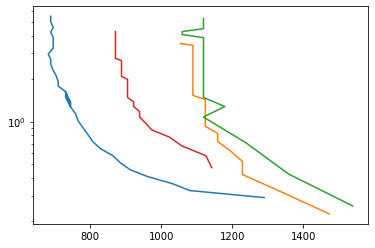

In [151]:
plt.plot(peak_collectPSP,f_fit_collectPSP,label='PSP')
plt.plot(peak_collectSTA,f_fit_collectSTA,label='STA')
plt.plot(peak_collectWI,f_fit_collectWI,label='WI')
plt.plot(peak_collectSOLO,f_fit_collectSOLO,label='SOLO')

plt.yscale('log')

TypeError: Dimensions of C (321, 141) are incompatible with X (141) and/or Y (128); see help(pcolor)

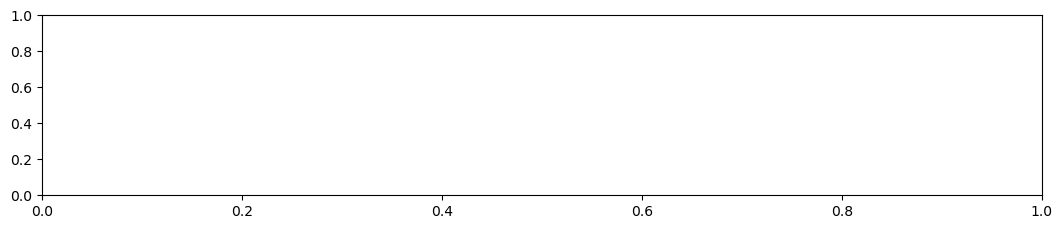

In [152]:
fig = plt.figure(figsize=[10,6],dpi=100)

ax =  fig.add_axes([0,0,1,0.3])
ax.pcolor(t_small, f_cur,np.log10(ds_small.T),vmin=2 ,vmax=5)
plt.yscale('log')
#plt.ylim([0.2,12])
plt.plot(peak_collect,f_cur[freq_idx_select],'C1.')
#plt.plot(peak_fit_collect,f_fit_collect,'m+')

In [105]:
ds_f_PSP[20]

0.16640625

In [106]:
[r_STA,r_WI,r_PSP,r_SOLO] = [0.964818 ,1.014672*0.99,0.151603,0.532474]
[alpha_STA,alpha_WI,alpha_PSP,alpha_SOLO] = np.array([-71.469,0,-149.558,41.863 ]) *np.pi/180

In [6]:
# x: [t0,theta0,vs]
v_sw = 400
Min_Func = lambda x:( SEMP.Dt_STA_WI_PSP(freq_STA,freq_WI,freq_PSP,
        t_STA,t_WI,t_PSP, x[:,0],x[:,1],x[:,2],v_sw,alpha_STA,alpha_WI,
        alpha_PSP,r_STA,r_WI,r_PSP,Ne_par=2.0) )


In [7]:
# Set-up hyperparameters
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of GlobalBestPSO
optimizer = pyswarms.single.GlobalBestPSO(n_particles=50, dimensions=3,
                                    options=options,bounds=([0,-0*np.pi,0],[5000,2*np.pi,3e5]))

In [8]:

stats = optimizer.optimize(Min_Func, iters=100)

2021-06-22 09:34:42,657 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=18.5
2021-06-22 09:34:44,754 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 18.4664485318217, best pos: [2.13636799e+03 4.54222602e+00 3.50306360e+04]


In [9]:
f_model = np.logspace(4.5,7,30)
t_model_STA = np.zeros(f_model.shape)
t_model_WI = np.zeros(f_model.shape)
t_model_PSP = np.zeros(f_model.shape)

for idx,freq in enumerate(f_model):
    t_model_PSP[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_PSP,r_satellite_AU=r_PSP,Ne_par=2.0)
    t_model_STA[idx] =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_STA,r_satellite_AU=r_STA,Ne_par=2.0)
    t_model_WI[idx]  =  SEMP.t_arrival_model(freq,stats[1][0],stats[1][1],stats[1][2], v_sw=400,alpha=alpha_WI,r_satellite_AU=r_WI,Ne_par=2.0)

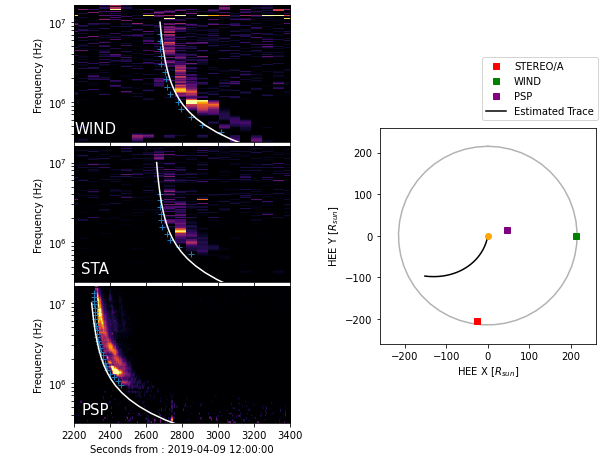

In [10]:
from matplotlib.image import NonUniformImage
fig = plt.figure(figsize=(5,6.5)) 
ax = fig.add_axes([0.15,0.2,0.6,0.29])

im = NonUniformImage(ax, interpolation='nearest',extent=[ds_t_PSP[0],ds_t_PSP[-1],ds_f_PSP[0],ds_f_PSP[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_PSP[0],ds_f_PSP[-1],ds_f_PSP.shape[0])
im.set_data(ds_t_PSP,lin_freq,(data_PSP.T))
ax.images.append(im)
ax.set_yscale('log')
im.set_clim([0,3e-16])
ax.set_xlim([2200,3400])
ax.set_ylim([ds_f_PSP[0],ds_f_PSP[-1]])
ax.set_aspect('auto', 'datalim')
ax.set_xlabel('Seconds from : '+str(anchor_dt))
ax.plot(t_PSP,freq_PSP,'C0+')
ax.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax.set_ylabel('Frequency (Hz)')
ax.text(0.1, 0.1,'PSP',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes,
     fontsize=15)

ax1 = fig.add_axes([0.15,0.5,0.6,0.29])

im1 = NonUniformImage(ax1, interpolation='nearest',extent=[ds_t_STA[0],ds_t_STA[-1],ds_f_STA[0],ds_f_STA[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_STA[0],ds_f_STA[-1],ds_f_STA.shape[0])
im1.set_data(ds_t_STA,lin_freq,(data_STA.T))
ax1.images.append(im1)
ax1.set_yscale('log')
im1.set_clim([0,2])
ax1.set_xlim([2200,3400])
ax1.set_ylim([ds_f_STA[0],ds_f_STA[-1]])
ax1.set_aspect('auto', 'datalim')
ax1.plot(t_STA,freq_STA,'C0+')
ax1.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax1.text(0.1, 0.1,'STA',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax1.transAxes,
     fontsize=15)
     
ax1.set_ylabel('Frequency (Hz)')
ax1.xaxis.set_ticklabels([]) 


ax2 = fig.add_axes([0.15,0.8,0.6,0.29])

im2 = NonUniformImage(ax2, interpolation='nearest',extent=[ds_t_WI[0],ds_t_WI[-1],ds_f_WI[0],ds_f_WI[-1]],cmap='inferno')
lin_freq = np.linspace(ds_f_WI[0],ds_f_WI[-1],ds_f_WI.shape[0])
im2.set_data(ds_t_WI,lin_freq,(data_WI.T))
ax2.images.append(im2)
ax2.set_yscale('log')
im2.set_clim([0,0.1])
ax2.set_xlim([2200,3400])
ax2.set_ylim([ds_f_WI[0],ds_f_WI[-1]])
ax2.set_aspect('auto', 'datalim')
ax2.plot(t_WI,freq_WI,'C0+')
ax2.yaxis.set_major_locator(plt.LogLocator(base=10,subs='all'))
ax2.text(0.1, 0.1,'WIND',color='w',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax2.transAxes,
     fontsize=15)
     
ax2.set_ylabel('Frequency (Hz)')
ax2.xaxis.set_ticklabels([]) 

ax.plot(t_model_PSP,f_model,'w')
ax1.plot(t_model_STA,f_model,'w')
ax2.plot(t_model_WI,f_model,'w')

#fig.savefig('img/PSP.pdf')


ax3 = fig.add_axes([1,0.3,0.6,0.6])

tmp_t = np.linspace(0,2*np.pi)
R_AU = SEMP.AU2km/SEMP.r_sun2km
r_sun2km = SEMP.r_sun2km
ax3.plot(np.sin(tmp_t)*R_AU,np.cos(tmp_t)*R_AU,'k-',alpha=0.3)
ax3.set_aspect('equal')
markWI,=ax3.plot(r_WI*np.cos(0)*R_AU,r_WI*np.sin(0)*R_AU,'s',color='green',label='WIND')
markSTA,=ax3.plot(r_STA*np.cos(alpha_STA)*R_AU,r_STA*np.sin(alpha_STA)*R_AU,'s',color='red',label='STEREO/A')
markPSP,=ax3.plot(r_PSP*np.cos(alpha_PSP)*R_AU,r_PSP*np.sin(alpha_PSP)*R_AU,'s',color='purple',label='PSP')

r = np.linspace(1,180,100)*r_sun2km
theta_spiral = SEMP.parkerSpiral(r,stats[1][1],v_sw)
markSpiral,=ax3.plot(r*np.cos(theta_spiral)/r_sun2km,r*np.sin(theta_spiral)/r_sun2km,'k',label='Estimated Trace')



ax3.plot(0,0,'o',color='orange')
ax3.set_xlim([-260,260])
ax3.set_ylim([-260,260])
ax3.set_xlabel(r'HEE X [$R_{sun}$]')
ax3.set_ylabel(r'HEE Y [$R_{sun}$]')

plt.legend(handles=[markSTA,markWI,markPSP, markSpiral],  bbox_to_anchor=(0.45, 1.35), loc='upper left')

fig.savefig('img/combined.pdf',bbox_inches='tight')


In [11]:
stats[1][1]*180/np.pi-360

-99.74961973848792

400